## Regresión Avanzada
## Clase 2

In [70]:
suppressMessages( library( readr ) )
suppressMessages( library( car ) )
suppressMessages( library( ggplot2 ) )
suppressMessages( library( lmtest ) )
suppressMessages( library( MASS ) )
suppressMessages( library( carData ) )
suppressMessages( library( robustbase ) )
suppressMessages( library( olsrr ) )
suppressMessages( library( quantreg ) )
suppressMessages( library( GGally ) )
suppressMessages( library( dplyr ) )
suppressMessages( library( kableExtra ) )

## 1. Análisis de Diagnóstico

### Validación de la normalidad: Estrategias analíticas

Se dispone de varios test: Shapiro-Wilks, Lilliefors, Anderson-Darling entre otros, todos ellos disponibles en R.

In [4]:
library( nortest ) # REALIZA 10 PRUEBAS DE NORMALIDAD #

SUPHOJA <- c( 44.09, 36.67, 51.72, 36.04, 38.97, 41.28, 42.06, 53.33, 40.14, 39.31, 33.53, 36.88, 36.94, 34.13, 42.03, 41.55 )
PESOF <- c( 49.29, 49, 43.04, 66.79, 63.11, 43.8, 39.63, 44.98, 21.44, 38.75, 40.96, 39.39, 54.7, 44.65, 39.65, 47.16 )
LONGF <- c( 46.34, 44.58, 40.06, 51.3, 50.7, 40.29, 39.71, 40.1, 29.63, 37, 37.38, 36.14, 49.33, 42.37, 37.4, 39.4 )

hojas <- data.frame( SUPHOJA, PESOF, LONGF )

mod_hojas <- lm( PESOF ~ LONGF, data = hojas )

residuos = residuals( mod_hojas )
shapiro.test( residuos )
ad.test( residuos )
lillie.test( residuos )


	Shapiro-Wilk normality test

data:  residuos
W = 0.95305, p-value = 0.5394



	Anderson-Darling normality test

data:  residuos
A = 0.27592, p-value = 0.6085



	Lilliefors (Kolmogorov-Smirnov) normality test

data:  residuos
D = 0.1077, p-value = 0.889


Conclusión: Todos los test coinciden en que puede sostenerse el supuesto de normalidad.

### Validación de la Normalidad: Estrategias gráficas

Los gráficos de cuantil-cuantil o qq-plots visibilizan los apartamientos respecto de la normalidad de los residuos del modelo ajustado.

[1] 16  1

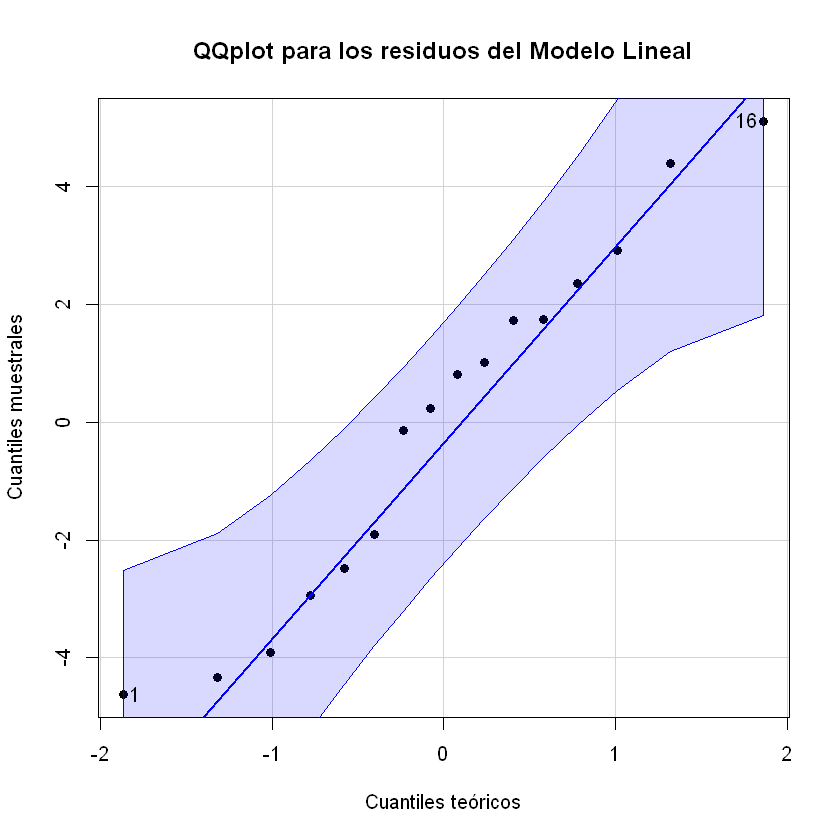

In [6]:
qqPlot( residuos, pch = 19,
    main = "QQplot para los residuos del Modelo Lineal",
    xlab = "Cuantiles teóricos",
    ylab = "Cuantiles muestrales" )

### Validación de la independencia

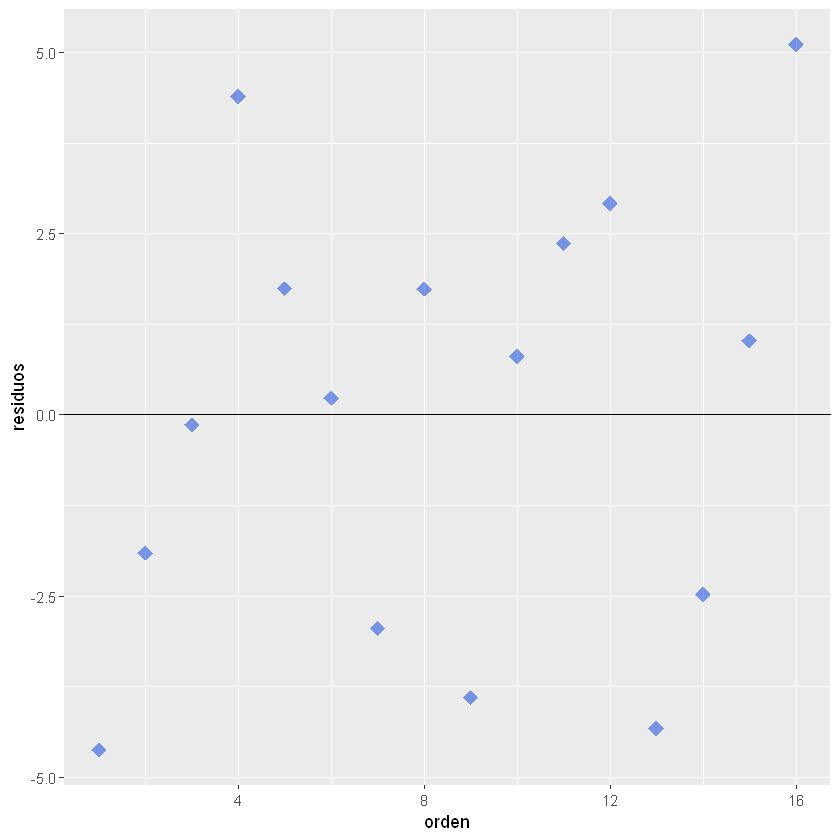

In [25]:
orden <- 1:nrow( hojas )
dwdata <- data.frame(orden = orden, residuos = residuos)

ggplot( dwdata, aes( x = orden, y = residuos ) ) +
    geom_point( color = "#013ADF", 
        fill = "#013ADF", 
        size = 4, 
        shape = 18, 
        alpha = 0.5 ) + 
    xlab( "orden" ) +
    geom_abline( slope = 0 )

Para realizar esta verificación analíticamente, se puede aplicar el test de Durbin-Watson.

In [10]:
dwtest( mod_hojas, alternative = "two.sided", iterations = 1000 )


	Durbin-Watson test

data:  mod_hojas
DW = 1.5159, p-value = 0.2612
alternative hypothesis: true autocorrelation is not 0


### Validación de la homocedasticidad

Existen varia pruebas como el test de Breusch- Pagan el de Gotfeld-Quandt disponibles en R.

In [14]:
bptest( mod_hojas )
gqtest( mod_hojas, order.by = LONGF, data = hojas )


	studentized Breusch-Pagan test

data:  mod_hojas
BP = 0.84363, df = 1, p-value = 0.3584



	Goldfeld-Quandt test

data:  mod_hojas
GQ = 1.4074, df1 = 6, df2 = 6, p-value = 0.3443
alternative hypothesis: variance increases from segment 1 to 2


### Validación Gráfica de la homocedasticidad

Se utiliza el gráfico de residuales versus la variable predictora que permite observar si el error del modelo aumenta o disminuye al aumentar la magnitud de los valores de la variable predictora. Una estructura
de "embudo" alerta respecto de heterocedasticidad.

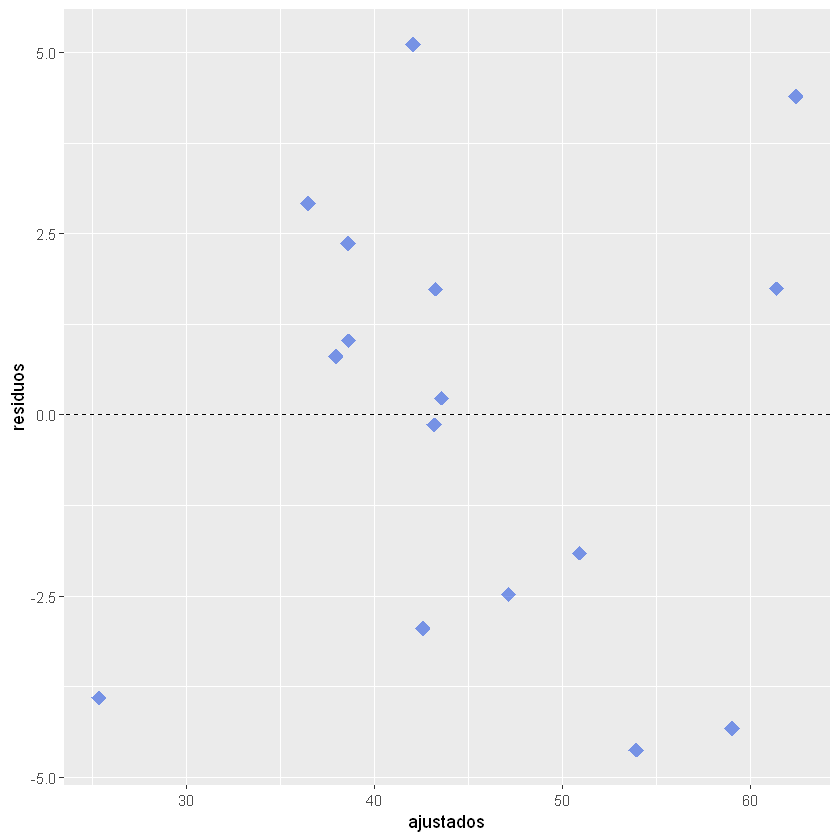

In [15]:
ajustados <- mod_hojas$fitted.values
databp <- data.frame( ajustados, residuos )

ggplot( databp, aes( x = ajustados, y = residuos ) ) +
    geom_point( color = "#013ADF", 
        fill = "#013ADF", 
        size = 4, 
        shape = 18, 
        alpha = 0.5) + 
    xlab( "ajustados" ) +
    geom_abline( slope = 0, linetype = "dashed" )

Si bien el test no rechaza la homocedasticidad de los errores el p valor es cercano al nivel de significación y se aprecia una leve estructura en la gráfica.

### Detección de Outliers

En ocasiones una observación o un subgrupo de observaciones puede presentarse muy alejado del conjunto mayoritario de observaciones o no seguir exactamente el patrón de relación del conjunto general. Esta
observación o conjunto de observaciones pueden ser outliers, pero también pueden ser valores influyentes. Veamos la aplicación en R para el ejemplo de los frutos de damasco:

In [13]:
outlierTest( mod_hojas )

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
   rstudent unadjusted p-value Bonferroni p
16 1.797485           0.095514           NA

La observación 16 quedó selalada como valor extremo u outlier. Es posible dibujar los resultados de la prueba de Bonferroni para cada observación. En la siguiente figura se observa que sólo la observación 16
es identificada como un posible outlier ya que su valor-p es muy pequeño.

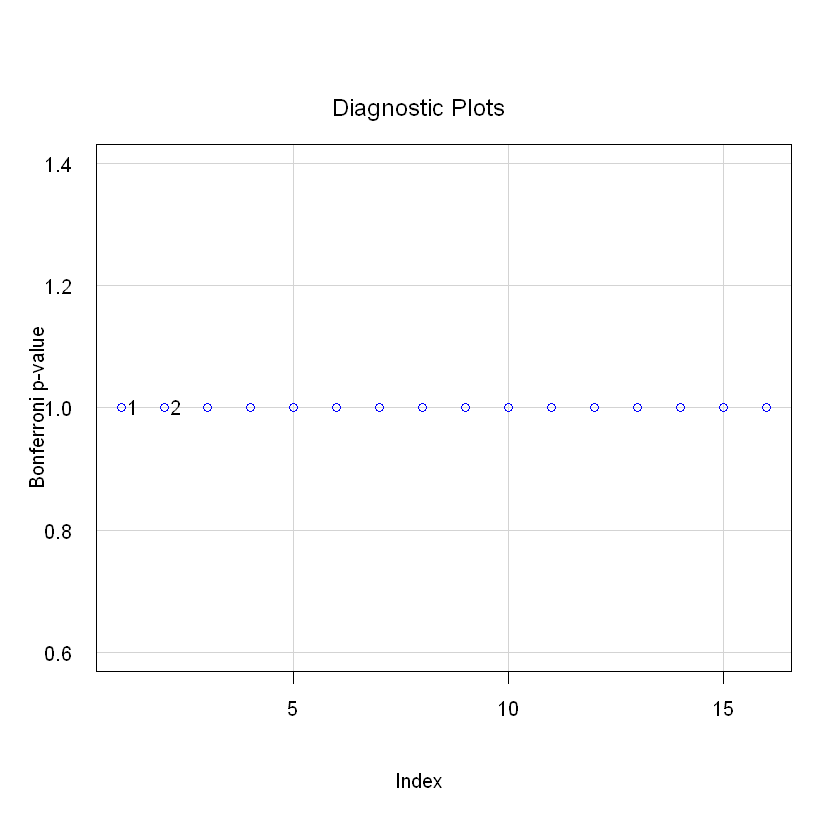

In [16]:
influenceIndexPlot( mod_hojas, vars="Bonf", las=1, col="blue")

### Distancia de Cook: aplicación

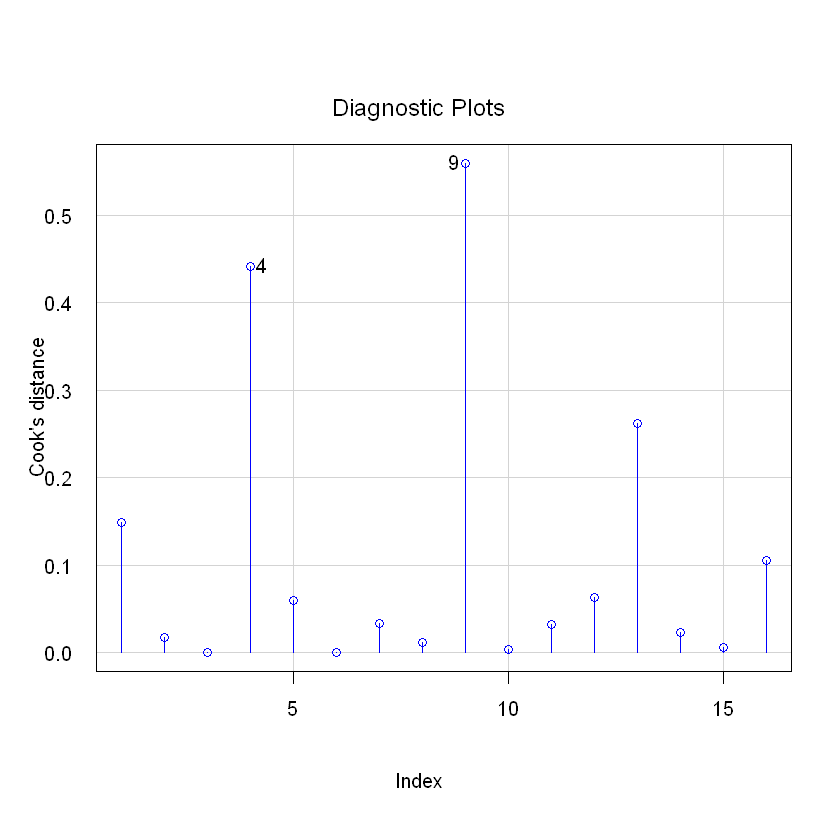

In [17]:
influenceIndexPlot( mod_hojas, vars = 'Cook' , las = 1, col = 'blue' )

### DFFITS

Cuantifican la influencia de la i-ésima observación sobre su propio valor predicho o ajustado. Las observaciones con DFFITS superiores a 2 sqrt( p/n ) en valor absoluto
se consideran influyentes.

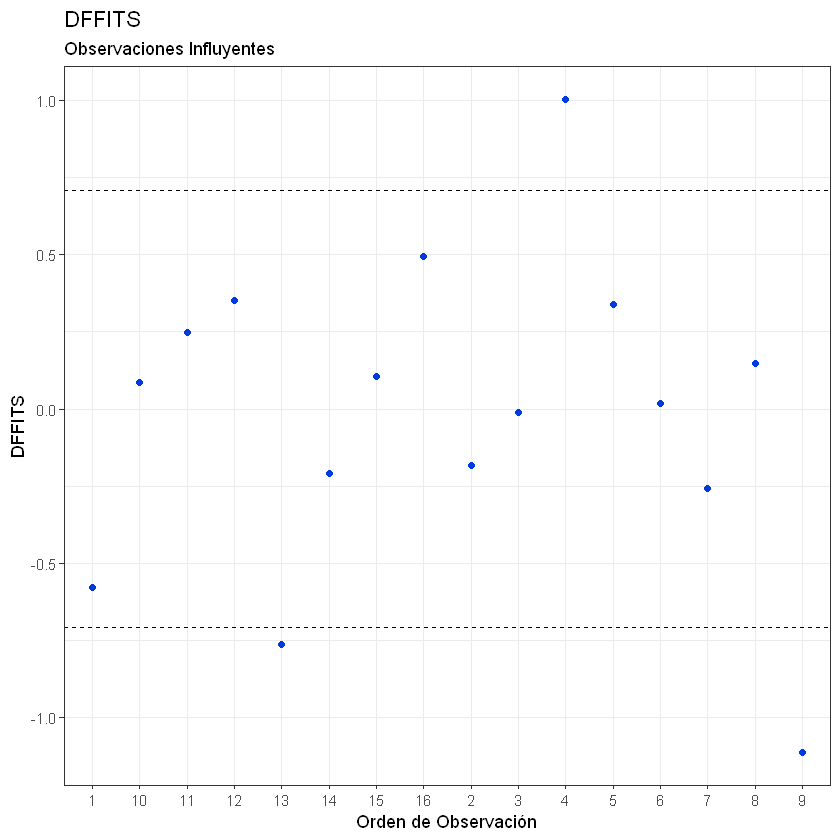

In [66]:
df <- mod_hojas$df.residual

p <- length( mod_hojas$coefficients )
n <- nrow( hojas )

dffits_crit <- 2*sqrt( p/n )
dffits <- dffits( mod_hojas )

df <- data.frame( obs = names( dffits ), dffits = dffits )

ggplot( df, aes( y = dffits, x = obs ) ) + 
    geom_point( color = '#013ADF' ) +
    geom_hline( yintercept = c( dffits_crit, -dffits_crit ), linetype = 'dashed' ) + 
    labs( title = 'DFFITS', 
        subtitle = 'Observaciones Influyentes' , 
        x = 'Orden de Observación' , 
        y = 'DFFITS' ) +
    theme_bw()

Nuevamente es la observación 16 la que se destaca con un valor alto de DFFITS.

### DFBETA

El valor de DFbeta indica el impacto de una observación sobre la estimación del coeficiente del modelo medido sobre dicho coeficiente, mientras que la distancia de Cook lo mide sobre los valores estimados.
El valor de corte para el DFBeta es 1.

Veamos cómo buscar en R observaciones con DFbeta alto, usamos nuevamente el ejemplo de los frutos de damasco:

In [39]:
print( dfbetas( mod_hojas )[,2] > 1 ) # esta función entrega los valores estandarizados

    1     2     3     4     5     6     7     8     9    10    11    12    13 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE 
   14    15    16 
FALSE FALSE FALSE 


En este caso tampoco se aprecian observaciones influyentes.

### Ejemplo 5: Pulpa de papel

Se pretende analizar la relación existente entre la concentración de madera de la pulpa de papel, y la resistencia del papel elaborado con ésta. El objetivo del análisis es describir y cuantificar la tendencia observada. Se utiliza la base de datos madera.xlsx disponible en: https://github.com/ferdcoz/mcd-reg-adv/blob/main/datasets/madera.csv

In [52]:
madera = read_csv( "https://raw.githubusercontent.com/ferdcoz/mcd-reg-adv/main/datasets/madera.csv" , show_col_types = FALSE)

New names:
• `` -> `...1`


In [53]:
mod_mad = lm( resist ~ madera, data = madera )
summary( mod_mad )


Call:
lm(formula = resist ~ madera, data = madera)

Residuals:
    Min      1Q  Median      3Q     Max 
-25.932  -3.922   2.907   7.742  15.840 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  21.4023     5.4742   3.910  0.00113 **
madera        1.7620     0.6541   2.694  0.01537 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.86 on 17 degrees of freedom
Multiple R-squared:  0.2992,	Adjusted R-squared:  0.258 
F-statistic: 7.257 on 1 and 17 DF,  p-value: 0.01537


Si bien el modelo es adecuado se observa que el valor del coeficiente de determinación no parece importante.

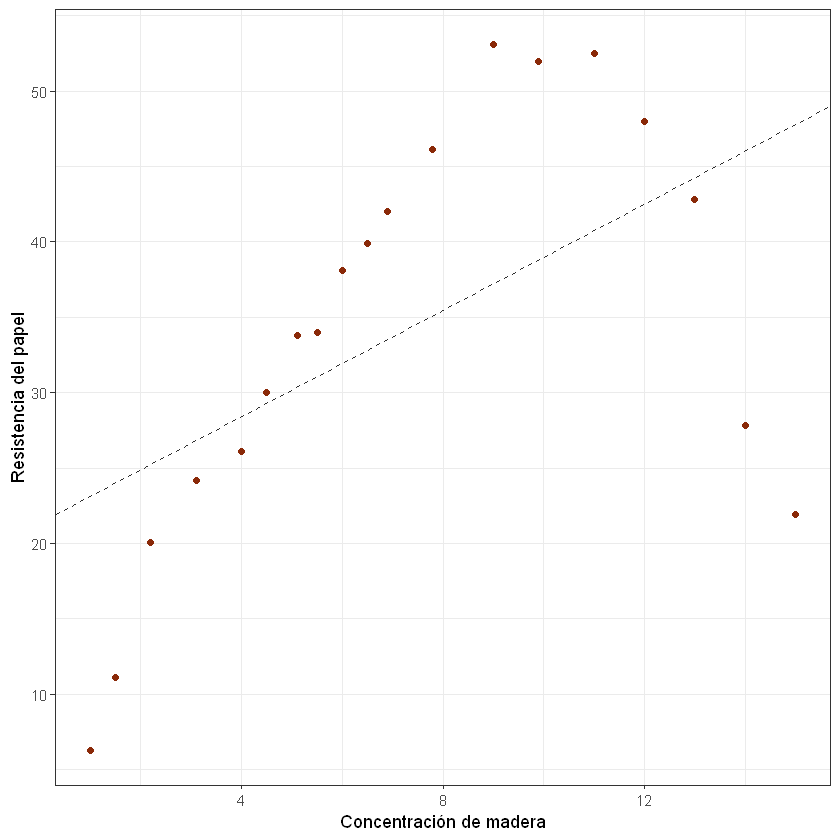

In [51]:
coef = mod_mad$coefficients

ggplot( madera, aes( madera, resist ) ) + 
    geom_point( color = '#8A2908' ) +
    geom_abline( intercept = coef[1], 
        slope = coef[2], 
        linetype = 'dashed' , 
        color = '#2E2E2E' ) +
    labs( x = 'Concentración de madera' , y = 'Resistencia del papel' ) +
    theme_bw()

### Análisis de normalidad de los residuos


	Shapiro-Wilk normality test

data:  residuals(mod_mad)
W = 0.93389, p-value = 0.2042


[1] 19 18

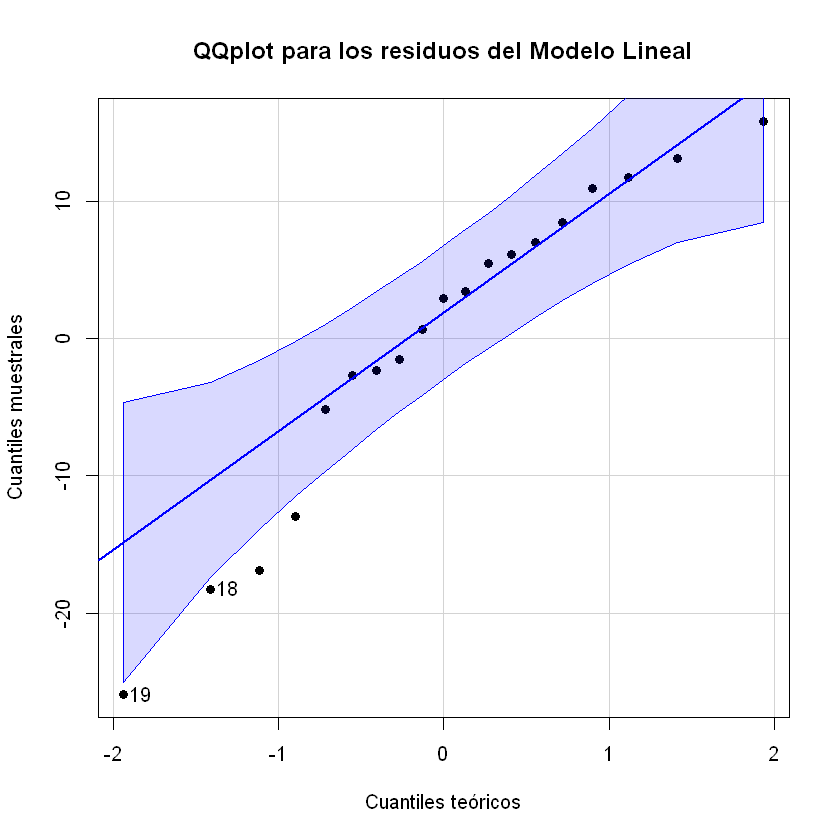

In [54]:
# Analizamos normalidad
shapiro.test( residuals( mod_mad ) )

qqPlot( residuals( mod_mad ), 
    pch = 19, 
    main = 'QQplot para los residuos del Modelo Lineal',
    xlab = 'Cuantiles teóricos',
    ylab = 'Cuantiles muestrales' )

No se aprecian apartamientos del supuesto de normalidad, ni en el test de Shapiro, ni en el qqplot, sin embargo se señalan un par de puntos problemáticos: el primero y el catorceavo.

### Independencia de los Residuos

In [55]:
# Analizamos independencia
dwtest( mod_mad, alternative ='two.sided', iterations = 1000 )


	Durbin-Watson test

data:  mod_mad
DW = 0.24226, p-value = 1.435e-09
alternative hypothesis: true autocorrelation is not 0


No se evidencian violaciones del supuesto de independencia.

### Buscamos Outliers

In [57]:
# Detectamos presencia de outliers
outlierTest( mod_mad )

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
    rstudent unadjusted p-value Bonferroni p
19 -3.050559          0.0076298      0.14497

### Bonferroni

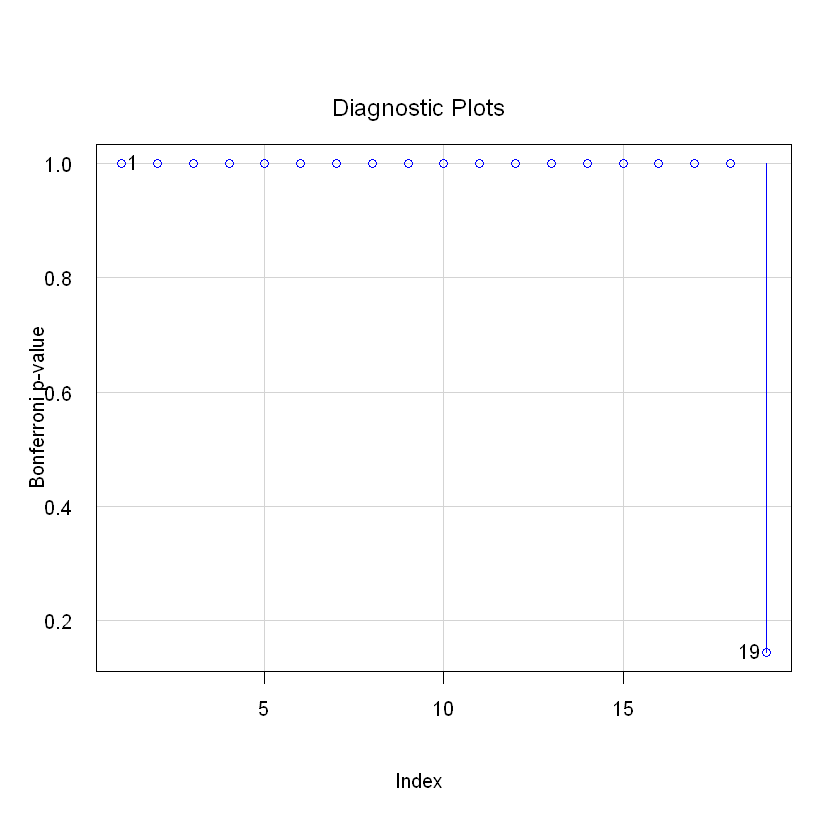

In [58]:
influenceIndexPlot( mod_mad, vars = 'Bonf', las = 1, col = 'blue')

Nuevamente se destacan las mismas observaciones que en el gráafico cuantil-cuantil de los residuos.

### Buscamos puntos influyentes

In [59]:
#Estudiamos el leverage
cota = 3 * mean( hatvalues( mod_mad ) ) 
leverage <- hatvalues( mod_mad ) > cota 
sum(leverage)

[1] 0

Primero definimos la cota para este modelo, luego sumamos la cantidad de observaciones que superan la cota y en este caso ninguna lo hace. Es decir que no hay valores influyentes.

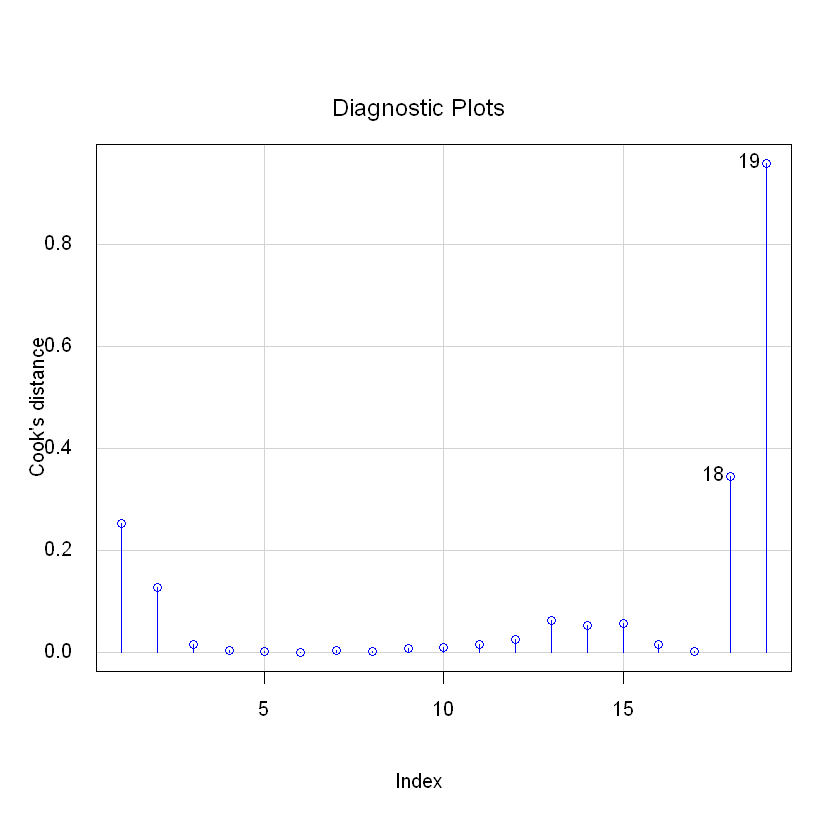

In [60]:
# Buscamos influencia por distancias de Cook
influenceIndexPlot( mod_mad, vars = 'Cook', las = 1, col = 'blue' )

La distancia de Cook correspondiente a las observaciones 1 y 14 quedan señaladas.

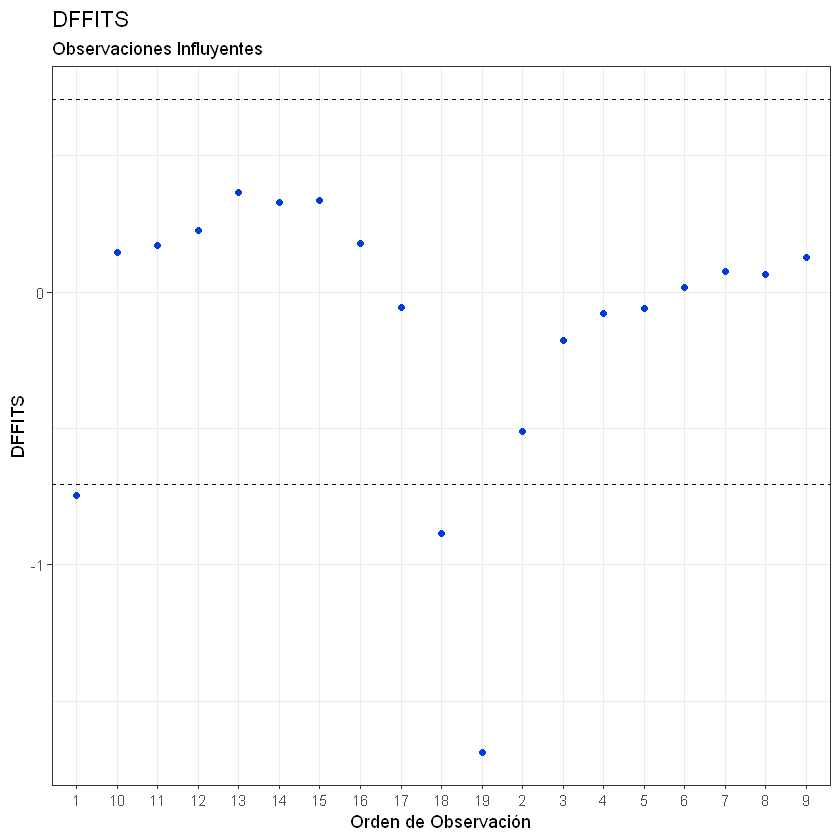

In [65]:
#Estudiamos los DFFITS

dffits_crit = 2 * sqrt( p/n )
dffits <- dffits( mod_mad )

df <- data.frame( obs = names( dffits ), dffits = dffits )

ggplot( df, aes( y = dffits, x = obs ) ) +
    geom_point( color = '#013ADF' ) +
    geom_hline( yintercept = c( dffits_crit, -dffits_crit ), 
        linetype = 'dashed' ) +
    labs( title = 'DFFITS', 
        subtitle = 'Observaciones Influyentes', 
        x = 'Orden de Observación', 
        y = 'DFFITS') + 
    theme_bw()

Las observaciones 1, 14 y 20 superan la cota establecida para los DFFITS. Con la cota 3 * sqrt ( p / n ), sóolo la observación 19 caería fuera.

In [63]:
# Estudiamos los DFBetas
sum( dfbetas( mod_mad )[, 2] > 1 )

[1] 0

No hay observaciones con DFBeta superior a la cota.

### Homocedasticidad de los Residuos


	studentized Breusch-Pagan test

data:  mod_mad
BP = 4.0786, df = 1, p-value = 0.04343


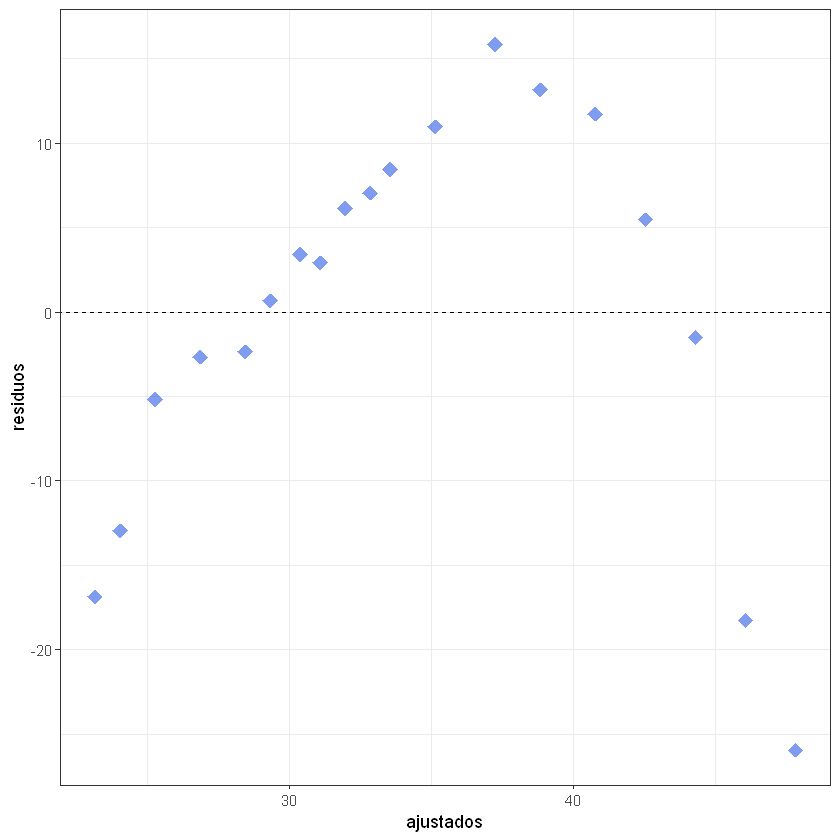

In [64]:
 # test de Breusch Pagan
bptest( mod_mad )

ajustados <- mod_mad$fitted.values
residuos <- residuals( mod_mad )
databp <- data.frame( ajustados, residuos )

ggplot( databp, aes( x = ajustados, y = residuos ) ) +
    geom_point( color = '#013ADF', 
        fill = '#013ADF', 
        size = 4, 
        shape = 18, 
        alpha = 0.5) + 
    xlab( 'ajustados') +
    geom_abline( slope = 0, linetype = 'dashed') +
    theme_bw()

No se rechaza la hipótesis de homocedasticidad de los residuos, pero se aprecia estructura en los mismos.

### ¿Cómo podemos resolver este problema?

Vamos a incorporar una nueva variable al modelo sugerida por la estructura de los residuos. Nos estamos yendo a un modelo de regresión lineal múltiple dado que estamos proponiendo dos variables predictoras o explicativas.

In [67]:
mod_mad2 <- lm( resist ~ madera + I( madera**2 ), data = madera )

summary( mod_mad2 )


Call:
lm(formula = resist ~ madera + I(madera^2), data = madera)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8124 -3.1623 -0.4507  4.0181  6.4429 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.51750    3.35526  -2.241   0.0396 *  
madera      11.95650    0.98378  12.154 1.71e-09 ***
I(madera^2) -0.64419    0.06034 -10.676 1.10e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.288 on 16 degrees of freedom
Multiple R-squared:  0.9137,	Adjusted R-squared:  0.9029 
F-statistic: 84.73 on 2 and 16 DF,  p-value: 3.069e-09


### Interpretación de la salida

* Ambos coeficientes resultan significativos.

* La regresión es significativa.

* El poder explicativo del modelo aumentó considerablemente.

Sin embargo, resta realizar el análisis diagnóstico del nuevo modelo.


	studentized Breusch-Pagan test

data:  mod_mad2
BP = 7.4048, df = 2, p-value = 0.02466


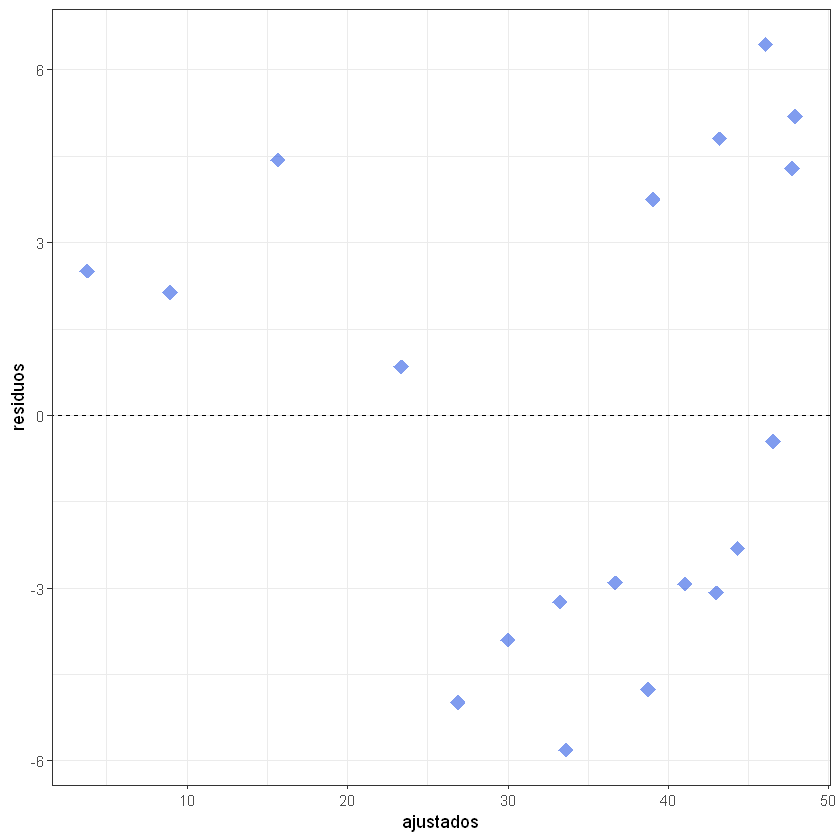

In [68]:
 # test de Breusch Pagan
bptest( mod_mad2 )

ajustados <- mod_mad2$fitted.values
residuos <- residuals( mod_mad2 )
databp <- data.frame( ajustados, residuos )

ggplot( databp, aes( x = ajustados, y = residuos ) ) +
    geom_point( color = '#013ADF', 
        fill = '#013ADF', 
        size = 4, 
        shape = 18, 
        alpha = 0.5) + 
    xlab( 'ajustados') +
    geom_abline( slope = 0, linetype = 'dashed') +
    theme_bw()

### Conclusiones Finales

Todos los análisis realizados se repiten y no aparecen outliers ni observaciones muy influyentes, luego volvemos a graficar los residuos versus los ajustados y visualizamos que ya no hay estructura.

### Ejemplo 7: cars

Utilizamos la base de datos cars de la biblioteca datasets, Intentaremos ajustar un modelo para estimar la distancia en función de la velocidad.

In [69]:
data( 'cars', package = 'datasets' )

mod_cars <- lm( dist ~ speed, data = cars )

summary( mod_cars ) # Visualizamos el ajuste del modelo propuesto


Call:
lm(formula = dist ~ speed, data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.069  -9.525  -2.272   9.215  43.201 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -17.5791     6.7584  -2.601   0.0123 *  
speed         3.9324     0.4155   9.464 1.49e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15.38 on 48 degrees of freedom
Multiple R-squared:  0.6511,	Adjusted R-squared:  0.6438 
F-statistic: 89.57 on 1 and 48 DF,  p-value: 1.49e-12


El modelo ajusta razonablemente bien, sin embargo falta analizar los supuestos del modelo. Veamos la normalidad de los residuos.

In [70]:
# Analizamos la normalidad de los residuos
shapiro.test( mod_cars$residuals )


	Shapiro-Wilk normality test

data:  mod_cars$residuals
W = 0.94509, p-value = 0.02152


[1] 49 23

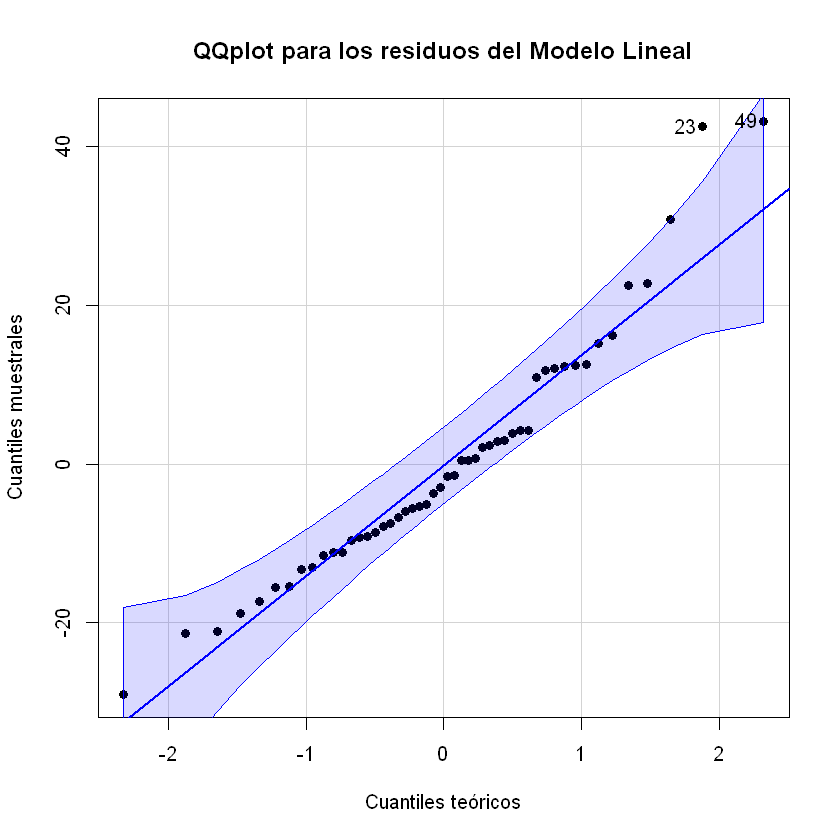

In [71]:
qqPlot( mod_cars$residuals, pch = 19,
    main = "QQplot para los residuos del Modelo Lineal",
    xlab = "Cuantiles teóricos",
    ylab = "Cuantiles muestrales" )

Vemos que los residuos no satisfacen el supuesto de normalidad.

### Transformación de Box & Cox

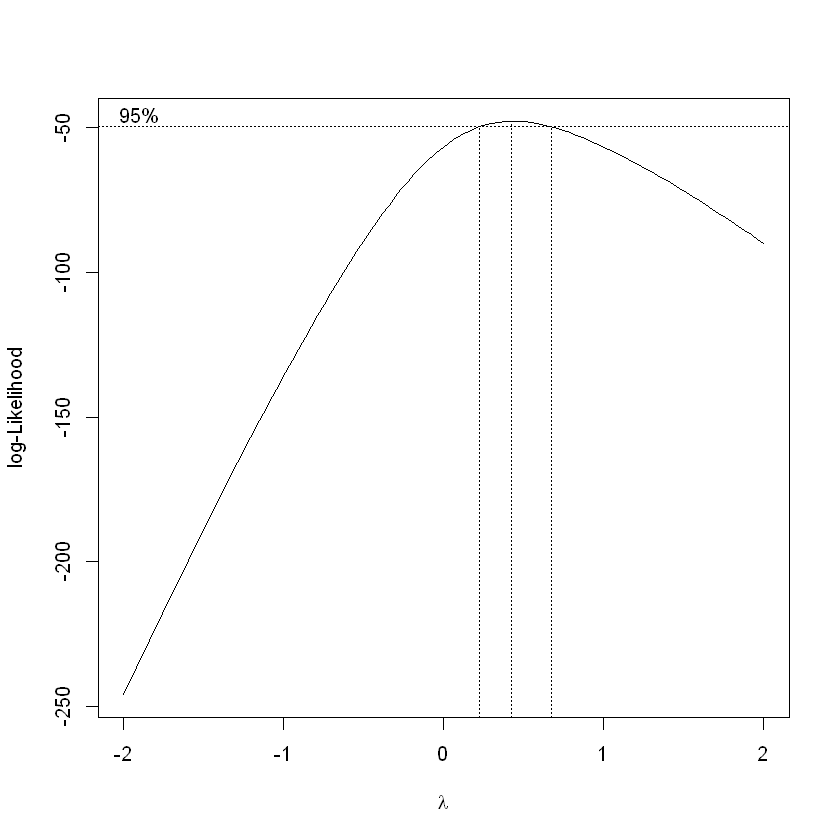

In [77]:
# Buscamos la mejor transf de Box & Cox para normalizar los residuos
boxcox( object = mod_cars, plotit = TRUE )

El gráfico señala que la mejor opción de λ es cercana a 0.5. También se puede pedir el valor exacto de la grilla que maximiza la logverosimilitud.

In [74]:
mod_cars2 <- lm( dist^0.5 ~ speed, data = cars )

summary( mod_cars2 ) # Visualizamos el ajuste del nuevo modelo propuesto


Call:
lm(formula = dist^0.5 ~ speed, data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0684 -0.6983 -0.1799  0.5909  3.1534 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.27705    0.48444   2.636   0.0113 *  
speed        0.32241    0.02978  10.825 1.77e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.102 on 48 degrees of freedom
Multiple R-squared:  0.7094,	Adjusted R-squared:  0.7034 
F-statistic: 117.2 on 1 and 48 DF,  p-value: 1.773e-14


[1] 23 35

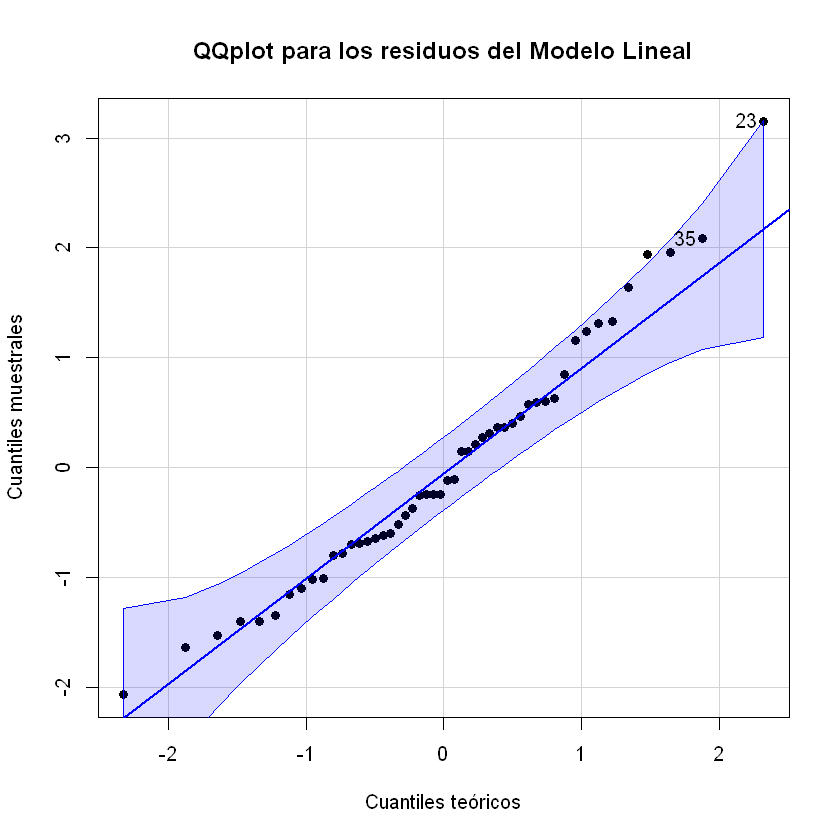

In [75]:
qqPlot( mod_cars2$residuals, pch = 19,
    main = "QQplot para los residuos del Modelo Lineal",
    xlab = "Cuantiles teóricos",
    ylab = "Cuantiles muestrales" )

Ahora se satisface el supuesto de normalidad de los residuos, sin embargo debemos ser cuidadosos en la interpretación del modelo.

## 2. Cuadrados Mínimos Ponderados

### Ejemplo 8: choferes

Se desea estimar el número de inspectores adecuado para una línea de transporte urbano basado en el número de choferes de la misma. Para ello se dispone de datos de 29 líneas de transporte de esa ciudad y su correspondiente
número de choferes. Los datos están en: 

In [ ]:
# Ajustamos un modelo de cuadrados mínimos ordinarios
ols_inspec <- lm( inspectores ~ choferes, data = inspectores )
summary( ols_inspec )

El modelo planteado resulta significativo, falta verificar el cumplimiento de los supuestos del modelo.

In [ ]:
resid_inspec <- ols_inspec$residuals # almacenamos los residuos
ajust_insp <- ols_inspec$fitted.values # idem valores ajustados
shapiro.test( resid_inspec ) # testeamos la normalidad de los residuos
bptest(ols_inspec) # verificamos el supuesto de homocedasticidad

Se verifica normalidad, pero no se verifica homocedasticidad. Inspeccionamos la gráfica los residuos vs valores ajustados.

In [ ]:
ggplot( dat_insp, aes( x = ajust_insp, y = resid_inspec ) ) +
    geom_point( color = '#013ADF', 
        fill = '#013ADF', 
        size = 4,
        shape = 18, 
        alpha = 0.5) + 
    xlab( 'ajustados' )+
    geom_abline( slope = 0, linetype = 'dashed') +
    theme_bw()

Se aprecia en esta figura que la variabilidad de los residuos aumenta conforme aumentan los valores ajustados. Vamos a intentar con un modelo de cuadrados mínimos ponderados.

In [ ]:
fited <- lm( abs( ols_inspec$residuals ) ~ ols_inspec$fitted.values )$residuals
pesos <- I( 1/ols_inspec$fitted.values2 ) # definimos el modelo con los pesos
wls_inspec <- lm( inspectores ~ choferes, weights = pesos, data = inspectores )
summary( wls_inspec )

Este modelo también es adecuado, el valor del R2 adj es similar pero el valor residual en el primero es 64.47, mientras que en el segundo es 0.339, lo cual dice que este último es mejor.

## 3. Modelos Robustos

### Ejemplo 8: Modelos Robustos en R

La base de datos Duncan disponible en la biblioteca 'carData' tiene 45 observaciones y 4 variables. Estos datos corresponden a ocupaciones de
EEUU con sus correspondientes valoraciones de prestigio en el año 1950.

* type: factor con tipo de ocupación. Niveles: docente, profesional, gerencial; de cuello blanco y cuello azul.

* income: porcentaje de personas ocupadas con ese cargo en el censo de 1950 que ganaban más de 3500 dólares por año.

* education: porcentaje de personas ocupadas con ese cargo que tenían terminados sus estudios secundarios.

* prestige: porcentajes de opiniones en una encuesta que valoraron el cargo como prestigioso.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


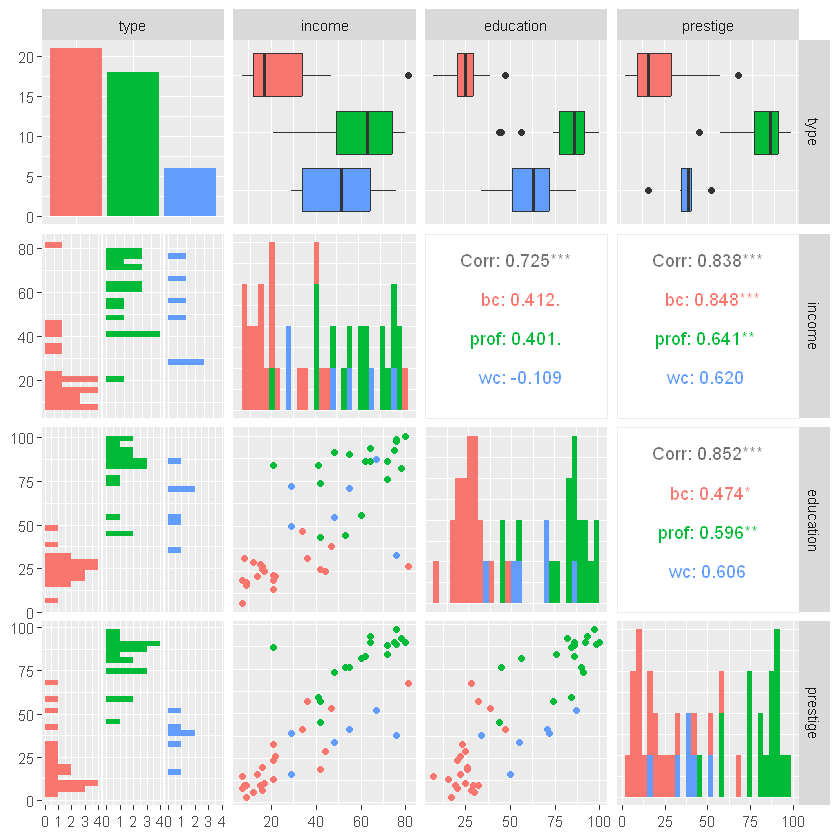

In [28]:
ggpairs( Duncan, mapping = aes(color = type) )

Se aprecia una relación lineal razonable entre el ingreso, la educación y el prestigio. Vamos a tratar de explicar el ingreso a partir de la educaciónn.

In [3]:
# ajustamos un modelo lineal por OLS y visualizamos la calidad del ajuste
duncan_lm <- lm( income ~ education, data = Duncan )
summary( duncan_lm )


Call:
lm(formula = income ~ education, data = Duncan)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.572 -11.346  -1.501   9.669  53.740 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.6035     5.1983   2.040   0.0475 *  
education     0.5949     0.0863   6.893 1.84e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17.04 on 43 degrees of freedom
Multiple R-squared:  0.5249,	Adjusted R-squared:  0.5139 
F-statistic: 47.51 on 1 and 43 DF,  p-value: 1.84e-08


### Calidad del ajuste

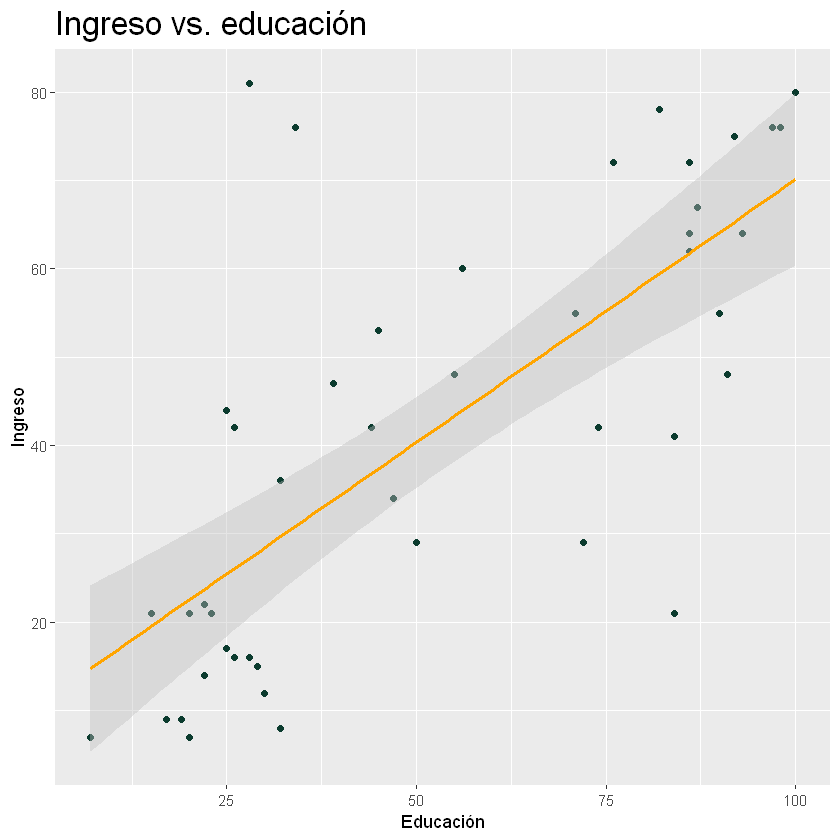

In [38]:
ggplot( Duncan, aes( x = education, y = income ) )+
    geom_point( col="#0B3B2E" ) +
    geom_smooth( method=lm, formula=y~x, se=TRUE, level=0.95, col="orange", fill="gray") +
    labs(x = "Educación", y = "Ingreso", title = "Ingreso vs. educación") +
    theme(plot.title = element_text(size = 20))

Se observa la presencia de datos alejados de la recta de ajuste, pueden ser outliers y también puntos influyentes. Vamos a realizar el análisis diagnóstico del modelo.

### Normalidad de los residuos

In [42]:
residuos <- duncan_lm$residuals
shapiro.test( residuos )


	Shapiro-Wilk normality test

data:  residuos
W = 0.93746, p-value = 0.01736


RR.engineer   conductor 
         27          16

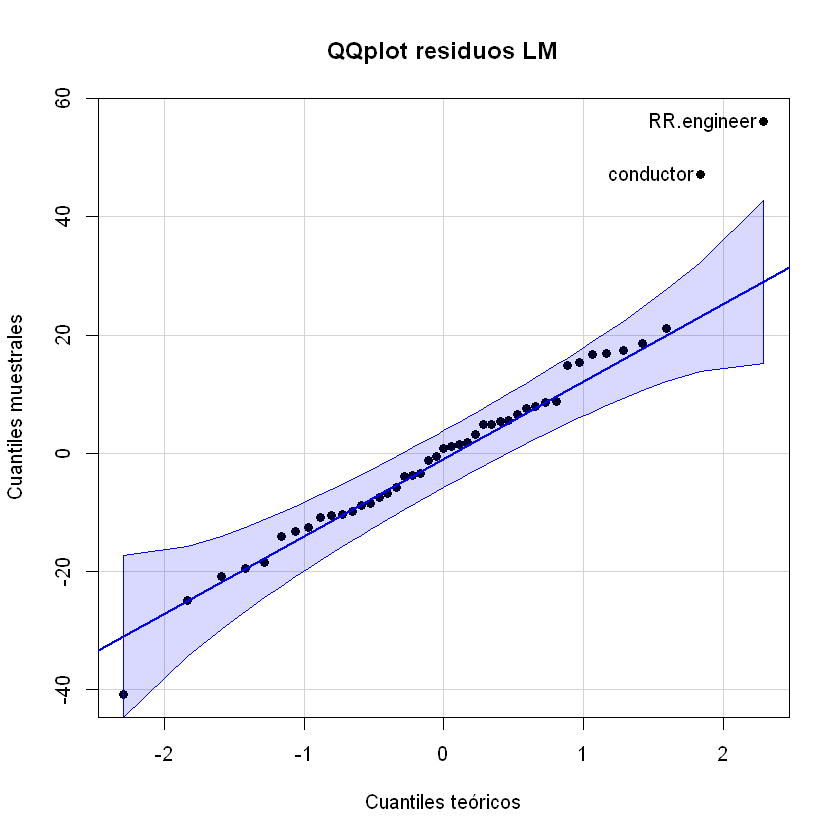

In [43]:
qqPlot( residuos, pch = 19,
    main = "QQplot residuos LM",
    xlab = "Cuantiles teóricos",
    ylab = "Cuantiles muestrales" )

### Homocedasticidad de los residuos

In [58]:
bptest( duncan_lm )


	studentized Breusch-Pagan test

data:  duncan_lm
BP = 0.28649, df = 1, p-value = 0.5925


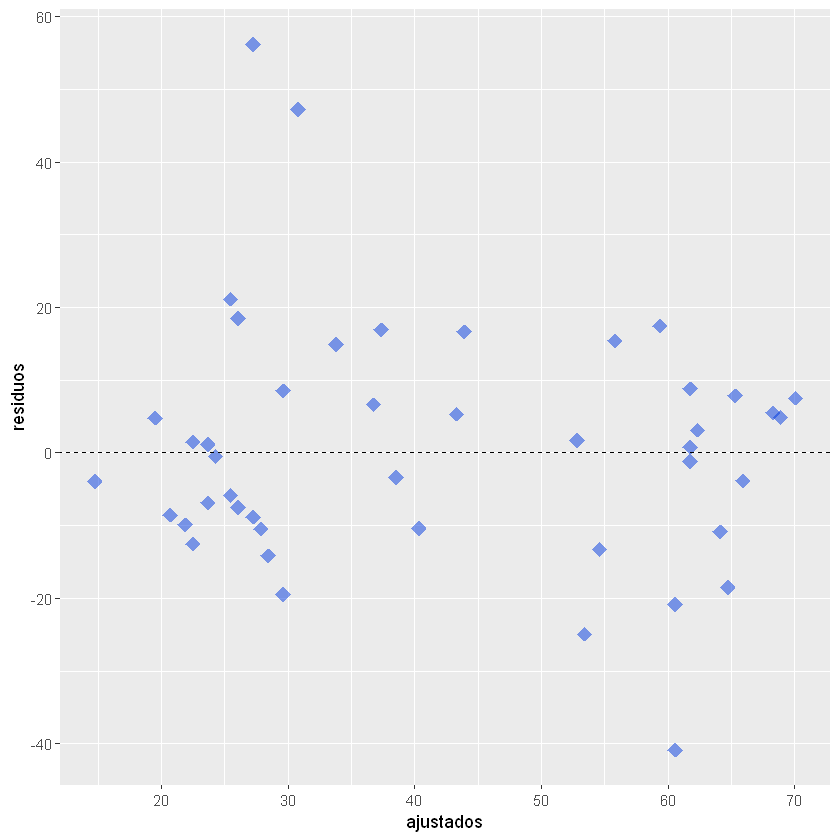

In [59]:
ajustados <- duncan_lm$fitted.values
databp <- data.frame( ajustados, residuos )

ggplot( databp, aes( x = ajustados, y = residuos ) ) +
    geom_point( color = "#013ADF", 
        fill = "#013ADF", 
        size = 4, 
        shape = 18, 
        alpha = 0.5) + 
    xlab( "ajustados" ) +
    geom_abline( slope = 0, linetype = "dashed" )

### Exploramos la presencia de outliers

In [60]:
outlierTest( duncan_lm )

            rstudent unadjusted p-value Bonferroni p
RR.engineer 3.646444         0.00072729     0.032728

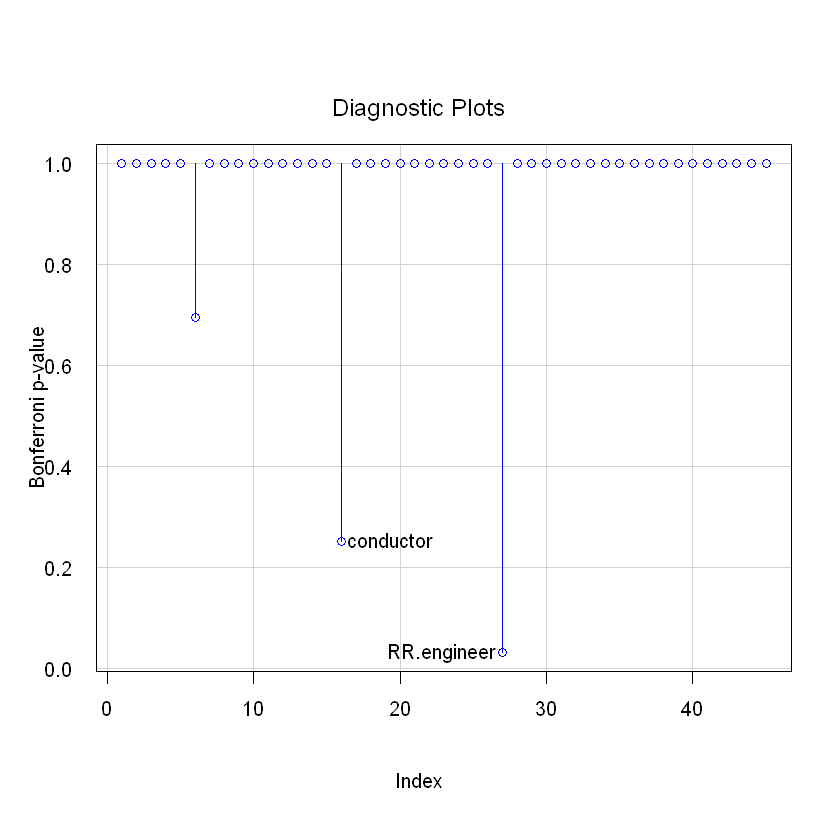

In [61]:
influenceIndexPlot( duncan_lm, vars = 'Bonf', las = 1, col = 'blue')

Se aprecian como atípicos los valores del ingeniero y del conductor.

### Medidas de Influencia

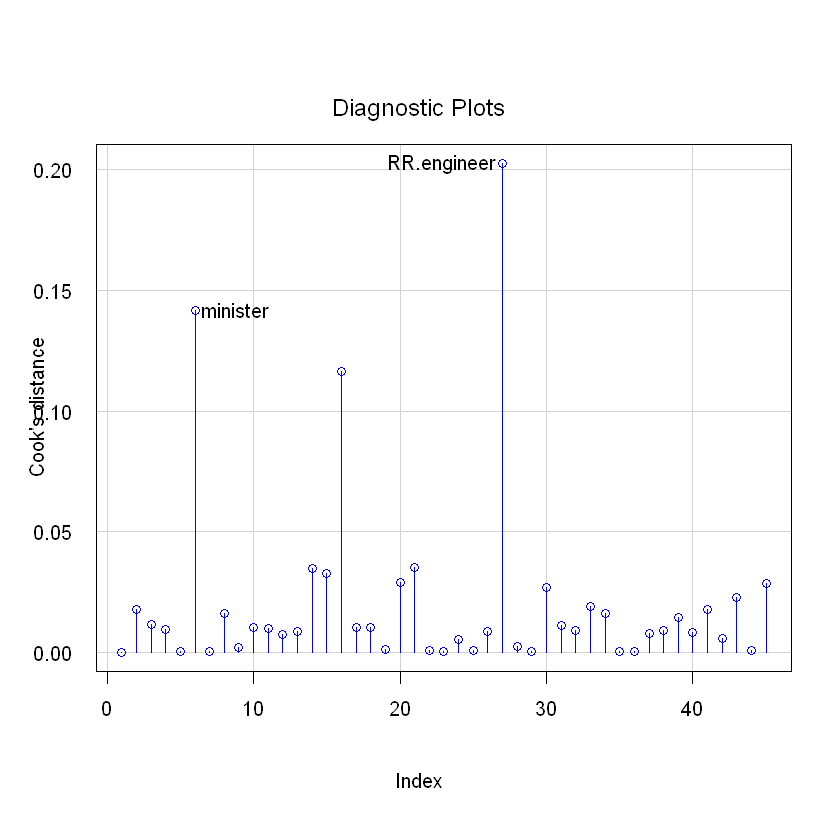

In [62]:
influenceIndexPlot( duncan_lm, vars = 'Cook', las = 1, col = 'blue' )

No se detectan valores con alto leverage, si con distancia de Cook por encima de la cota.

### DDFITS y DFBETA

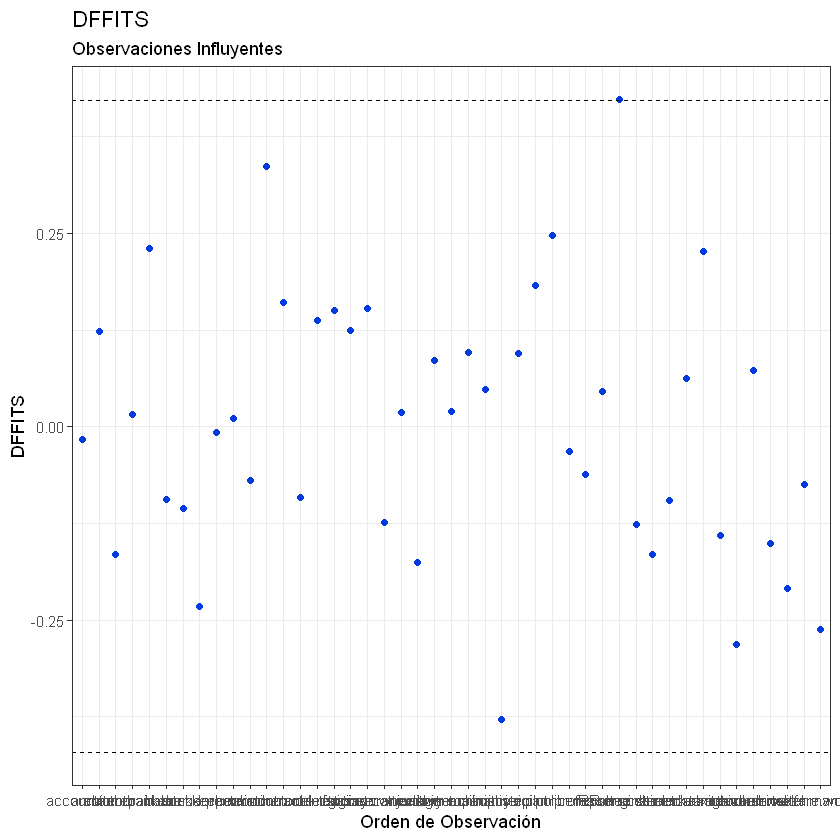

In [52]:
df <- duncan.lm$df.residual

p <- length( duncan.lm$coefficients )
n <- nrow( Duncan )

dffits_crit = 2 * sqrt( p/n )
dffits <- dffits( duncan.lm )

df <- data.frame( obs = names( dffits ), dffits = dffits )

ggplot( df, aes( y = dffits, x = obs ) ) +
    geom_point( color = '#013ADF' ) +
    geom_hline( yintercept = c( dffits_crit, -dffits_crit ), 
        linetype = 'dashed' ) +
    labs( title = 'DFFITS', 
        subtitle = 'Observaciones Influyentes', 
        x = 'Orden de Observación', 
        y = 'DFFITS') + 
    theme_bw()

Las observaciones de los DFFITS y de los DFBeta no denotan valores atípicos, mientras que en el caso de las distancias de Cook se señalan dos casos especiales el ministro y el ingeniero.

### Estimación Robusta por Huber

In [68]:
# Ajustamos un modelo robusto con la propuesta de Huber
duncan_Huber <- rlm( income ~ education, data = Duncan, k2 = 1.345 )
duncan_Huber 

Call:
rlm(formula = income ~ education, data = Duncan, k2 = 1.345)
Converged in 9 iterations

Coefficients:
(Intercept)   education 
  6.3002197   0.6615263 

Degrees of freedom: 45 total; 43 residual
Scale estimate: 13.1 

### Estimación Robusta por LTS

In [12]:
# Ajustamos un modelo robusto con la propuesta de LTS
duncan_LTS <- lqs( income ~ education, data = Duncan, method = 'lts' )
duncan_LTS

Call:
lqs.formula(formula = income ~ education, data = Duncan, method = "lts")

Coefficients:
(Intercept)    education  
    -2.6929       0.8125  

Scale estimates 10.43 11.19 


### Estimación Robusta por LAD

In [13]:
# Ajustamos un modelo robusto con la propuesta de LAD
duncan_LAD <- rq( income ~ education, data = Duncan, tau = 0.5 )
duncan_LAD

Call:
rq(formula = income ~ education, tau = 0.5, data = Duncan)

Coefficients:
(Intercept)   education 
       1.75        0.75 

Degrees of freedom: 45 total; 43 residual

### Comparamos gráficamente las estimaciones

### Comparación analítica de los ajustes

In [75]:
# Fijamos una semilla para reproducibilidad
set.seed(2)

# Separamos la base
train = Duncan %>% sample_frac( 0.8 ) 
test = Duncan %>% setdiff( train )

# Guardamos la v.resp de test
income = test$income 

# Guardamos predichos
ols_Predicted <- predict( duncan_lm, test ) 
lts_Predicted <- predict( duncan_LTS, test )
lad_Predicted <- predict( duncan_LAD, test )
hub_Predicted <- predict( duncan_Huber, test )

# Armamos base con observados y ajustados
ols_pred <- cbind( ols_Predicted, income ) 
lts_pred <- cbind( lts_Predicted, income )
lad_pred <- cbind( lad_Predicted, income )
hub_pred <- cbind( hub_Predicted, income )
EM_OLS <- mean( apply( ols_pred, 1, min ) / apply( ols_pred, 1, max ) )
EM_LTS <- mean( apply( lts_pred, 1, min ) / apply( lts_pred, 1, max ) )
EM_LAD <- mean( apply( lad_pred, 1, min ) / apply( lad_pred, 1, max ) )
EM_HUB <- mean( apply( hub_pred, 1, min ) / apply( hub_pred, 1, max ) )

EM <- c( EM_OLS, EM_LTS, EM_HUB, EM_LAD )
sal <- cbind( EM )
rownames(sal) <- c( 'OLS', 'LTS', 'HUB', 'LAD') 

#Usando Kable
#sal %>% kbl() %>% kable_classic()

print( sal )

           EM
OLS 0.7808577
LTS 0.7776089
HUB 0.8077907
LAD 0.7982088


Los errores medios cometidos definidos como el promedio de las proporciones entre el mínimo y máximo entre ajustado y observado es similar, aunque el M-estimador de Huber logra mejorar esta proporción levemente. En cuanto al coeficiente de determinación el LAD logra el mejor ajuste. Hay que destacar que la separación de conjuntos de testeo y validación se hace con una semilla aleatoria, al variar esta semilla pueden variar estos valores.